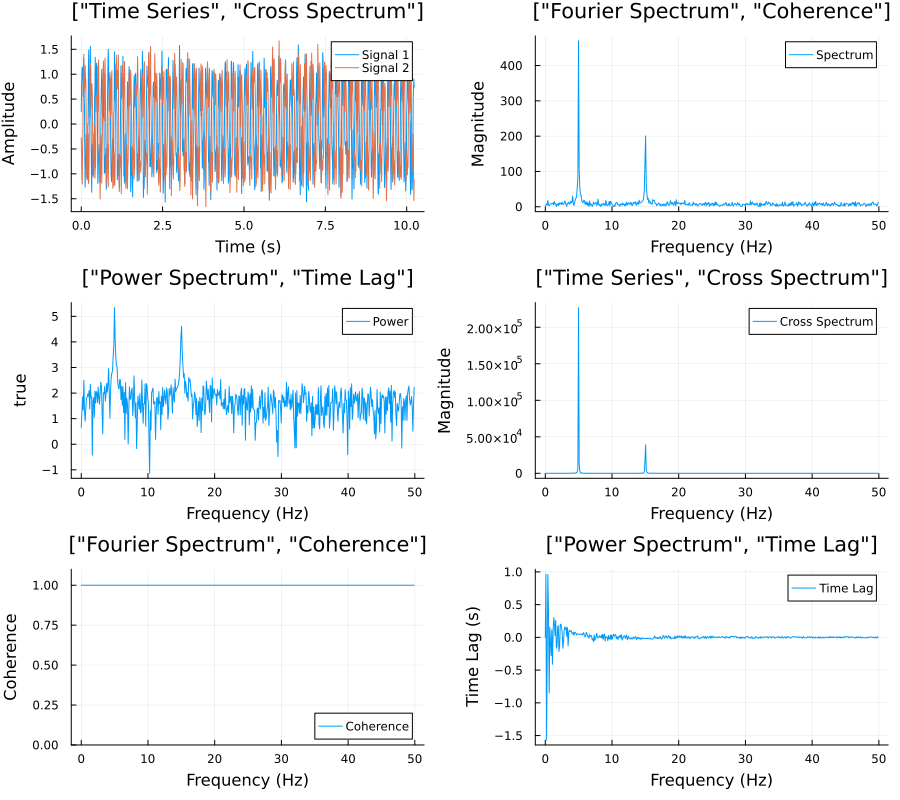

In [11]:
using FFTW
using LinearAlgebra
using Statistics
using Plots
using RecipesBase

# Abstract type for different kinds of signal data
abstract type AbstractSignal end

# Basic time series data structure
struct TimeSeries{T<:Real} <: AbstractSignal
    time::Vector{T}
    values::Vector{T}
    dt::T
    
    # Constructor with validation
    function TimeSeries(time::Vector{T}, values::Vector{T}) where T<:Real
        @assert length(time) == length(values) "Time and values vectors must have the same length"
        @assert issorted(time) "Time vector must be sorted"
        dt = length(time) > 1 ? time[2] - time[1] : zero(T)
        new{T}(time, values, dt)
    end
    
    # Constructor from values with uniform time steps
    function TimeSeries(values::Vector{T}, dt::T = 0.01) where T<:Real
        N = length(values)
        time = collect(range(0, step=dt, length=N))
        new{T}(time, values, dt)
    end
end

# Fourier transformed signal
struct FourierSignal{T<:Real} <: AbstractSignal
    frequencies::Vector{T}
    amplitudes::Vector{Complex{T}}
    dt::T
    N::Int
    
    # Constructor that validates input
    function FourierSignal(freqs::Vector{T}, amps::Vector{Complex{T}}, dt::T, N::Int) where T<:Real
        @assert length(freqs) == length(amps) "Frequencies and amplitudes must have the same length"
        new{T}(freqs, amps, dt, N)
    end
end

# Cross spectrum between two signals
struct CrossSpectrum{T<:Real} <: AbstractSignal
    frequencies::Vector{T}
    values::Vector{Complex{T}}
    
    function CrossSpectrum(freqs::Vector{T}, vals::Vector{Complex{T}}) where T<:Real
        @assert length(freqs) == length(vals) "Frequencies and values must have the same length"
        new{T}(freqs, vals)
    end
end

# Power spectrum data
struct PowerSpectrum{T<:Real} <: AbstractSignal
    frequencies::Vector{T}
    powers::Vector{T}
    
    function PowerSpectrum(freqs::Vector{T}, powers::Vector{T}) where T<:Real
        @assert length(freqs) == length(powers) "Frequencies and powers must have the same length"
        new{T}(freqs, powers)
    end
end

# Coherence data between two signals
struct CoherenceSpectrum{T<:Real} <: AbstractSignal
    frequencies::Vector{T}
    coherence::Vector{T}
    time_lag::Vector{T}
    
    function CoherenceSpectrum(freqs::Vector{T}, coh::Vector{T}, lag::Vector{T}) where T<:Real
        @assert length(freqs) == length(coh) == length(lag) "All vectors must have the same length"
        new{T}(freqs, coh, lag)
    end
end

# Function to compute the Fourier transform of a lightcurve
function fourier_transform(signal::TimeSeries{T}) where T<:Real
    N = length(signal.values)
    F = fft(signal.values)
    freq = fftfreq(N, 1.0/signal.dt)
    
    # Sort by frequency to ensure proper ordering
    idx = sortperm(freq)
    return FourierSignal(freq[idx], F[idx], signal.dt, N)
end

# Compute the cross spectrum of two light curves
function cross_spectrum(signal1::TimeSeries{T}, signal2::TimeSeries{T}) where T<:Real
    @assert length(signal1.values) == length(signal2.values) "Signals must have the same length"
    @assert signal1.dt ≈ signal2.dt "Signals must have the same time step"
    
    F1 = fourier_transform(signal1)
    F2 = fourier_transform(signal2)
    
    cross_values = F1.amplitudes .* conj.(F2.amplitudes)
    return CrossSpectrum(F1.frequencies, cross_values)
end

# Compute the cross spectrum from two Fourier signals
function cross_spectrum(f1::FourierSignal{T}, f2::FourierSignal{T}) where T<:Real
    @assert length(f1.amplitudes) == length(f2.amplitudes) "Fourier signals must have the same length"
    @assert f1.frequencies ≈ f2.frequencies "Frequency arrays must match"
    
    cross_values = f1.amplitudes .* conj.(f2.amplitudes)
    return CrossSpectrum(f1.frequencies, cross_values)
end

# Compute the power density spectrum (PDS) from a light curve
function power_spectrum(signal::TimeSeries{T}) where T<:Real
    F = fourier_transform(signal)
    powers = abs2.(F.amplitudes)
    return PowerSpectrum(F.frequencies, powers)
end

# Compute the power spectrum from a Fourier signal
function power_spectrum(fourier::FourierSignal{T}) where T<:Real
    powers = abs2.(fourier.amplitudes)
    return PowerSpectrum(fourier.frequencies, powers)
end

# Calculate the time lag from the cross spectrum
function time_lag(cs::CrossSpectrum{T}) where T<:Real
    phase_lag = angle.(cs.values)
    
    # Avoid division by zero at DC (zero frequency)
    lags = zeros(T, length(phase_lag))
    for i in eachindex(phase_lag)
        if abs(cs.frequencies[i]) > eps(T)
            lags[i] = phase_lag[i] / (2π * cs.frequencies[i])
        end
    end
    
    return lags
end

# Compute coherence from the cross spectrum and the individual power spectra
function coherence(cs::CrossSpectrum{T}, pds1::PowerSpectrum{T}, pds2::PowerSpectrum{T}) where T<:Real
    @assert length(cs.values) == length(pds1.powers) == length(pds2.powers) "All spectra must have the same length"
    @assert cs.frequencies ≈ pds1.frequencies ≈ pds2.frequencies "Frequency arrays must match"
    
    # Coherence is defined as |Cross Spectrum|^2 divided by the product of the power spectra
    coh_values = abs2.(cs.values) ./ (pds1.powers .* pds2.powers)
    lags = time_lag(cs)
    
    return CoherenceSpectrum(cs.frequencies, coh_values, lags)
end

# Function to get positive frequencies only (up to Nyquist)
function positive_frequencies(signal::AbstractSignal)
    if signal isa FourierSignal
        pos_idx = findall(signal.frequencies .>= 0)
        return FourierSignal(
            signal.frequencies[pos_idx],
            signal.amplitudes[pos_idx],
            signal.dt,
            signal.N
        )
    elseif signal isa CrossSpectrum
        pos_idx = findall(signal.frequencies .>= 0)
        return CrossSpectrum(
            signal.frequencies[pos_idx],
            signal.values[pos_idx]
        )
    elseif signal isa PowerSpectrum
        pos_idx = findall(signal.frequencies .>= 0)
        return PowerSpectrum(
            signal.frequencies[pos_idx],
            signal.powers[pos_idx]
        )
    elseif signal isa CoherenceSpectrum
        pos_idx = findall(signal.frequencies .>= 0)
        return CoherenceSpectrum(
            signal.frequencies[pos_idx],
            signal.coherence[pos_idx],
            signal.time_lag[pos_idx]
        )
    end
    return signal  # Return original if not a frequency-domain signal
end

#================================================
    PLOTTING RECIPES
================================================#

# Recipe for TimeSeries
@recipe function f(ts::TimeSeries)
    title --> "Time Series"
    xlabel --> "Time (s)"
    ylabel --> "Amplitude"
    label --> "Signal"
    grid --> true
    
    ts.time, ts.values
end

# Recipe for comparing multiple TimeSeries
@recipe function f(ts_array::AbstractVector{<:TimeSeries})
    title --> "Time Series Comparison"
    xlabel --> "Time (s)"
    ylabel --> "Amplitude"
    grid --> true
    layout --> (1, 1)
    
    for (i, ts) in enumerate(ts_array)
        @series begin
            label --> "Signal $i"
            ts.time, ts.values
        end
    end
end

# Recipe for FourierSignal - shows magnitude spectrum
@recipe function f(fs::FourierSignal; nyquist_only=true)
    title --> "Fourier Spectrum"
    xlabel --> "Frequency (Hz)"
    ylabel --> "Magnitude"
    label --> "Spectrum"
    grid --> true
    
    # Option to show only up to Nyquist frequency
    if nyquist_only
        idx = findall(fs.frequencies .>= 0)
        freqs = fs.frequencies[idx]
        mags = abs.(fs.amplitudes[idx])
    else
        freqs = fs.frequencies
        mags = abs.(fs.amplitudes)
    end
    
    freqs, mags
end

# Recipe for Phase Spectrum
@recipe function f(fs::FourierSignal, ::Val{:phase}; nyquist_only=true)
    title --> "Phase Spectrum"
    xlabel --> "Frequency (Hz)"
    ylabel --> "Phase (radians)"
    label --> "Phase"
    grid --> true
    
    # Option to show only up to Nyquist frequency
    if nyquist_only
        idx = findall(fs.frequencies .>= 0)
        freqs = fs.frequencies[idx]
        phases = angle.(fs.amplitudes[idx])
    else
        freqs = fs.frequencies
        phases = angle.(fs.amplitudes)
    end
    
    freqs, phases
end

# Recipe for PowerSpectrum
@recipe function f(ps::PowerSpectrum; nyquist_only=true, log_scale=true)
    title --> "Power Spectrum"
    xlabel --> "Frequency (Hz)"
    ylabel --> log_scale ? "Log Power" : "Power"
    label --> "Power"
    grid --> true
    
    # Option to show only up to Nyquist frequency
    if nyquist_only
        idx = findall(ps.frequencies .>= 0)
        freqs = ps.frequencies[idx]
        powers = ps.powers[idx]
    else
        freqs = ps.frequencies
        powers = ps.powers
    end
    
    # Option for log scale
    if log_scale
        powers = log10.(powers .+ eps())  # Add eps to avoid log(0)
    end
    
    freqs, powers
end

# Recipe for CrossSpectrum magnitude
@recipe function f(cs::CrossSpectrum; nyquist_only=true)
    title --> "Cross Spectrum Magnitude"
    xlabel --> "Frequency (Hz)"
    ylabel --> "Magnitude"
    label --> "Cross Spectrum"
    grid --> true
    
    # Option to show only up to Nyquist frequency
    if nyquist_only
        idx = findall(cs.frequencies .>= 0)
        freqs = cs.frequencies[idx]
        mags = abs.(cs.values[idx])
    else
        freqs = cs.frequencies
        mags = abs.(cs.values)
    end
    
    freqs, mags
end

# Recipe for CrossSpectrum phase
@recipe function f(cs::CrossSpectrum, ::Val{:phase}; nyquist_only=true)
    title --> "Cross Spectrum Phase"
    xlabel --> "Frequency (Hz)"
    ylabel --> "Phase (radians)"
    label --> "Phase"
    grid --> true
    
    # Option to show only up to Nyquist frequency
    if nyquist_only
        idx = findall(cs.frequencies .>= 0)
        freqs = cs.frequencies[idx]
        phases = angle.(cs.values[idx])
    else
        freqs = cs.frequencies
        phases = angle.(cs.values)
    end
    
    freqs, phases
end

# Recipe for CoherenceSpectrum
@recipe function f(cs::CoherenceSpectrum; nyquist_only=true)
    title --> "Coherence Spectrum"
    xlabel --> "Frequency (Hz)"
    ylabel --> "Coherence"
    label --> "Coherence"
    grid --> true
    ylims --> (0, 1.1)  # Coherence is between 0 and 1
    
    # Option to show only up to Nyquist frequency
    if nyquist_only
        idx = findall(cs.frequencies .>= 0)
        freqs = cs.frequencies[idx]
        coherence = cs.coherence[idx]
    else
        freqs = cs.frequencies
        coherence = cs.coherence
    end
    
    freqs, coherence
end

# Recipe for Time Lag
@recipe function f(cs::CoherenceSpectrum, ::Val{:timelag}; nyquist_only=true)
    title --> "Time Lag"
    xlabel --> "Frequency (Hz)"
    ylabel --> "Time Lag (s)"
    label --> "Time Lag"
    grid --> true
    
    # Option to show only up to Nyquist frequency
    if nyquist_only
        idx = findall(cs.frequencies .>= 0)
        freqs = cs.frequencies[idx]
        lags = cs.time_lag[idx]
    else
        freqs = cs.frequencies
        lags = cs.time_lag
    end
    
    freqs, lags
end

# Recipe for complete signal analysis dashboard
@recipe function f(signal_tuple::Tuple{TimeSeries, TimeSeries, CoherenceSpectrum}, ::Val{:dashboard})
    ts1, ts2, coh_spectrum = signal_tuple
    
    # Set up a 3x2 layout
    layout --> (3, 2)
    size --> (1000, 800)
    
    # Time Series
    @series begin
        subplot --> 1
        title --> "Time Series"
        xlabel --> "Time (s)"
        ylabel --> "Amplitude"
        label --> ["Signal 1" "Signal 2"]
        grid --> true
        
        [ts1.time ts1.time], [ts1.values ts2.values]
    end
    
    # Power Spectra
    psd1 = power_spectrum(ts1)
    psd2 = power_spectrum(ts2)
    psd1_pos = positive_frequencies(psd1)
    psd2_pos = positive_frequencies(psd2)
    
    @series begin
        subplot --> 2
        title --> "Power Spectra"
        xlabel --> "Frequency (Hz)"
        ylabel --> "Log Power"
        label --> ["PSD 1" "PSD 2"]
        grid --> true
        
        [psd1_pos.frequencies psd1_pos.frequencies], 
        [log10.(psd1_pos.powers .+ eps()) log10.(psd2_pos.powers .+ eps())]
    end
    
    # Coherence
    coh_pos = positive_frequencies(coh_spectrum)
    
    @series begin
        subplot --> 3
        title --> "Coherence"
        xlabel --> "Frequency (Hz)"
        ylabel --> "Coherence"
        label --> "Coherence"
        grid --> true
        ylims --> (0, 1.1)
        
        coh_pos.frequencies, coh_pos.coherence
    end
    
    # Phase
    cs = cross_spectrum(ts1, ts2)
    cs_pos = positive_frequencies(cs)
    
    @series begin
        subplot --> 4
        title --> "Phase"
        xlabel --> "Frequency (Hz)"
        ylabel --> "Phase (rad)"
        label --> "Phase"
        grid --> true
        
        cs_pos.frequencies, angle.(cs_pos.values)
    end
    
    # Time Lag
    @series begin
        subplot --> 5
        title --> "Time Lag"
        xlabel --> "Frequency (Hz)"
        ylabel --> "Time Lag (s)"
        label --> "Time Lag"
        grid --> true
        
        coh_pos.frequencies, coh_pos.time_lag
    end
    
    # Cross Spectrum Magnitude
    @series begin
        subplot --> 6
        title --> "Cross Spectrum"
        xlabel --> "Frequency (Hz)"
        ylabel --> "Magnitude"
        label --> "Cross Spectrum"
        grid --> true
        
        cs_pos.frequencies, abs.(cs_pos.values)
    end
end

# Example usage function with plots
function example_with_plots()
    # Parameters
    N = 1024                 # number of time bins
    dt = 0.01                # time resolution in seconds
    t = collect(0:dt:(N-1)*dt)  # time vector
    
    # For illustration, use random data plus a common sinusoidal signal
    # with a time delay between signals
    f1 = 5.0  # Hz
    f2 = 15.0 # Hz
    delay = 0.05  # 50 ms delay
    
    # Signal 1: Sum of two sinusoids plus noise
    common_signal1 = sin.(2π * f1 .* t) .+ 0.5 .* sin.(2π * f2 .* t)
    lc1_values = common_signal1 .+ 0.25 .* randn(N)
    
    # Signal 2: Same signals but with delay plus different noise
    common_signal2 = sin.(2π * f1 .* (t .- delay)) .+ 0.5 .* sin.(2π * f2 .* (t .- delay))
    lc2_values = common_signal2 .+ 0.25 .* randn(N)
    
    # Create TimeSeries objects
    lc1 = TimeSeries(t, lc1_values)
    lc2 = TimeSeries(t, lc2_values)
    
    # Plot time series
    p1 = plot(lc1, label="Signal 1")
    plot!(p1, lc2, label="Signal 2")
    
    # Plot multiple time series using the recipe for array of TimeSeries
    p2 = plot([lc1, lc2])
    
    # Compute Fourier transforms
    f1 = fourier_transform(lc1)
    f2 = fourier_transform(lc2)
    
    # Plot Fourier spectrum
    p3 = plot(f1)
    
    # Plot Phase spectrum using the phase recipe
    p4 = plot(f1, Val(:phase))
    
    # Compute power spectra
    pds1 = power_spectrum(lc1)
    pds2 = power_spectrum(lc2)
    
    # Plot power spectrum
    p5 = plot(pds1)
    
    # Compute cross spectrum
    cs = cross_spectrum(lc1, lc2)
    
    # Plot cross spectrum
    p6 = plot(cs)
    
    # Plot cross spectrum phase
    p7 = plot(cs, Val(:phase))
    
    # Calculate coherence (includes time lags)
    coh_spectrum = coherence(cs, pds1, pds2)
    
    # Plot coherence
    p8 = plot(coh_spectrum)
    
    # Plot time lag
    p9 = plot(coh_spectrum, Val(:timelag))
    
    # Create dashboard plot
    p10 = plot((lc1, lc2, coh_spectrum), Val(:dashboard))
    
    # Display all plots in a layout
    main_plot = plot(p1, p3, p5, p6, p8, p9, 
                    layout=(3,2), size=(900, 800),
                    title=["Time Series" "Fourier Spectrum" "Power Spectrum" 
                           "Cross Spectrum" "Coherence" "Time Lag"])
    
    return Dict(
        "time_series" => p1,
        "multi_time_series" => p2,
        "fourier" => p3,
        "phase" => p4,
        "power" => p5,
        "cross" => p6,
        "cross_phase" => p7,
        "coherence" => p8,
        "time_lag" => p9,
        "dashboard" => p10,
        "main_layout" => main_plot
    )
end

# Run the example with plots
plots = example_with_plots()

# Display the main layout plot
display(plots["main_layout"])
